In [1]:
import networkx as nx
import json
import logging
import os
import random # To pick sample nodes/edges

In [2]:
GRAPH_FILE = "DataExtract/Data/stackexchange_graph.gexf"
MAPPING_FILE = "DataExtract/Data/url_id_mapping.json"

NUM_SAMPLES = 5

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
def load_json_file(filename):
    """Loads data from a JSON file."""
    if not os.path.exists(filename):
        logging.error(f"Error: File '{filename}' not found.")
        return None
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return json.load(f)
    except json.JSONDecodeError as e:
        logging.error(f"Error decoding JSON from '{filename}': {e}")
        return None
    except Exception as e:
        logging.error(f"An error occurred while reading '{filename}': {e}")
        return None

In [5]:
print(f"Loading graph from {GRAPH_FILE}...") # Use print for status
if not os.path.exists(GRAPH_FILE):
    # Use logging for actual error conditions that might halt execution
    logging.error(f"Graph file '{GRAPH_FILE}' not found. Please run the graph building script first.")

try:
    G = nx.read_gexf(GRAPH_FILE, node_type=int)
    print("Graph loaded successfully.") # Use print for status
except Exception as e:
    logging.error(f"Failed to load or process graph from {GRAPH_FILE}: {e}")

print("Loading mappings...") # Use print for status
mappings = load_json_file(MAPPING_FILE)
if mappings is None or 'id_to_url' not in mappings:
    # Use logging for error/warning conditions
    logging.error("Failed to load ID-to-URL mappings. Inspection will use IDs only.")
    id_to_url = {} # Use an empty dict if mapping fails
else:
    # Need to convert string keys from JSON back to integers for id_to_url
    id_to_url = {int(k): v for k, v in mappings['id_to_url'].items()}
    print("Mappings loaded.") # Use print for status

Loading graph from DataExtract/Data/stackexchange_graph.gexf...
Graph loaded successfully.
Loading mappings...
Mappings loaded.


In [9]:
# --- Graph Inspection ---
print("\n--- Basic Graph Info ---")
# Use print for displaying results
print(f"Graph Type: {type(G)}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

if not G.nodes:
    logging.warning("Graph has no nodes. Exiting inspection.") # Warning is okay for logging

# --- Node Degree Inspection ---
print("\n--- Node Degree Samples ---")
sample_size = min(NUM_SAMPLES, G.number_of_nodes())
if sample_size > 0: # Check if there are nodes to sample
    sample_nodes = random.sample(list(G.nodes()), sample_size)
    for node_id in sample_nodes:
        url = id_to_url.get(node_id, f"ID {node_id}")
        in_degree = G.in_degree(node_id)
        out_degree = G.out_degree(node_id)
        # Use print for displaying results
        print(f"Node: {url}")
        print(f"  In-Degree (links pointing to this node): {in_degree}")
        print(f"  Out-Degree (links from this node): {out_degree}")
        print() # Add a blank line for spacing
else:
    print("No nodes available to sample for degree.")


# --- Neighbor Inspection ---
print("\n--- Node Neighbors Samples ---")
if sample_size > 0: # Check if there are nodes to sample
    # Use the same sample nodes if available
    for node_id in sample_nodes:
        url = id_to_url.get(node_id, f"ID {node_id}")
        successors = list(G.successors(node_id))
        predecessors = list(G.predecessors(node_id))

        # Use print for displaying results
        print(f"Node: {url}")
        num_succ_show = min(3, len(successors))
        successor_urls = [id_to_url.get(s_id, f"ID {s_id}") for s_id in successors[:num_succ_show]]
        print(f"  Sample Outgoing Links ({num_succ_show}/{len(successors)}): {successor_urls}")

        num_pred_show = min(3, len(predecessors))
        predecessor_urls = [id_to_url.get(p_id, f"ID {p_id}") for p_id in predecessors[:num_pred_show]]
        print(f"  Sample Incoming Links ({num_pred_show}/{len(predecessors)}): {predecessor_urls}")
        print() # Add a blank line for spacing
else:
        print("No nodes available to sample for neighbors.")

# --- Connectivity ---
print("\n--- Connectivity ---")
# Use print for displaying results
try:
    if G.number_of_nodes() > 0: # Check required for is_weakly_connected
        if nx.is_weakly_connected(G):
                print("The graph is weakly connected (all nodes reachable ignoring edge direction).")
        else:
                num_components = nx.number_weakly_connected_components(G)
                print(f"The graph is not weakly connected. Number of weakly connected components: {num_components}")
                largest_wcc = max(nx.weakly_connected_components(G), key=len)
                print(f"Size of the largest weakly connected component: {len(largest_wcc)} nodes")
    else:
        print("Graph has no nodes to check connectivity.")
except Exception as e:
        logging.error(f"Could not determine connectivity: {e}") # Log error if calculation fails


# --- Sample Centrality Calculation (Degree Centrality) ---
print("\n--- Sample Centrality (Degree) ---")
print(f"Calculating Out-Degree Centrality for all nodes...") # Print status
try:
    if G.number_of_nodes() > 0:
        out_degree_centrality = nx.out_degree_centrality(G)
        sorted_nodes_by_out_degree = sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True)

        # Use print for displaying results
        print(f"Top {NUM_SAMPLES} nodes by Out-Degree Centrality:")
        for i in range(min(NUM_SAMPLES, len(sorted_nodes_by_out_degree))):
            node_id, centrality = sorted_nodes_by_out_degree[i]
            url = id_to_url.get(node_id, f"ID {node_id}")
            print(f"  {i+1}. Node: {url} - Centrality: {centrality:.4f} (Out-Degree: {G.out_degree(node_id)})")
    else:
        print("Graph has no nodes to calculate centrality.")
except Exception as e:
    logging.error(f"Could not calculate centrality: {e}") # Log error if calculation fails



--- Basic Graph Info ---
Graph Type: <class 'networkx.classes.digraph.DiGraph'>
Number of nodes: 9202
Number of edges: 92834

--- Node Degree Samples ---
Node: https://stackoverflow.com/questions/18547476/how-multiple-threads-invoke-singleton-objects-method-and-work-on-them/18547527
  In-Degree (links pointing to this node): 0
  Out-Degree (links from this node): 11

Node: https://stackoverflow.com/questions/115983/how-do-i-add-an-empty-directory-to-a-git-repository/43917066
  In-Degree (links pointing to this node): 0
  Out-Degree (links from this node): 11

Node: https://stackoverflow.com/questions/23463391/github-pages-custom-domain-setup-with-hover
  In-Degree (links pointing to this node): 1
  Out-Degree (links from this node): 10

Node: https://stackoverflow.com/questions/22197496/how-to-perform-action-on-clicking-a-qmenu-object-only
  In-Degree (links pointing to this node): 0
  Out-Degree (links from this node): 10

Node: https://stackoverflow.com/questions/13210867/non-static

In [7]:
import matplotlib.pyplot as plt
from urllib.parse import urlparse

In [8]:
SAMPLE_SIZE = 1000  # How many nodes to include in the visualization sample
NODE_SIZE = 50
FONT_SIZE = 8
LABEL_TYPE = "id"

In [10]:
def get_node_labels(node_ids, id_to_url_map, label_type="id"):
    """Creates labels for nodes based on the specified type."""
    labels = {}
    for node_id in node_ids:
        if label_type == "path":
            url = id_to_url_map.get(node_id)
            if url:
                try:
                    # Extract the path and take the last part
                    path = urlparse(url).path.strip('/')
                    # Handle potential empty paths or just '/'
                    label = path.split('/')[-1] or f"ID:{node_id}"
                    # Limit label length if needed
                    labels[node_id] = label[:20] # Truncate long paths
                except Exception:
                    labels[node_id] = f"ID:{node_id}" # Fallback
            else:
                labels[node_id] = f"ID:{node_id}" # Fallback if URL missing
        else: # Default to "id"
            labels[node_id] = str(node_id)
    return labels

2025-05-03 00:56:14,365 - INFO - Loading graph from DataExtract/Data/stackexchange_graph.gexf...
2025-05-03 00:56:15,047 - INFO - Graph loaded: 9202 nodes, 92834 edges.
2025-05-03 00:56:15,047 - INFO - Loading mappings...
2025-05-03 00:56:15,059 - INFO - Mappings loaded.
2025-05-03 00:56:15,059 - INFO - Sampling 1000 nodes for visualization...
2025-05-03 00:56:15,066 - INFO - Created subgraph with 1000 nodes and 7 edges.
2025-05-03 00:56:15,066 - INFO - Calculating layout for the subgraph (this may take a moment)...
2025-05-03 00:56:19,496 - INFO - Drawing graph...
2025-05-03 00:56:19,998 - INFO - Displaying plot...


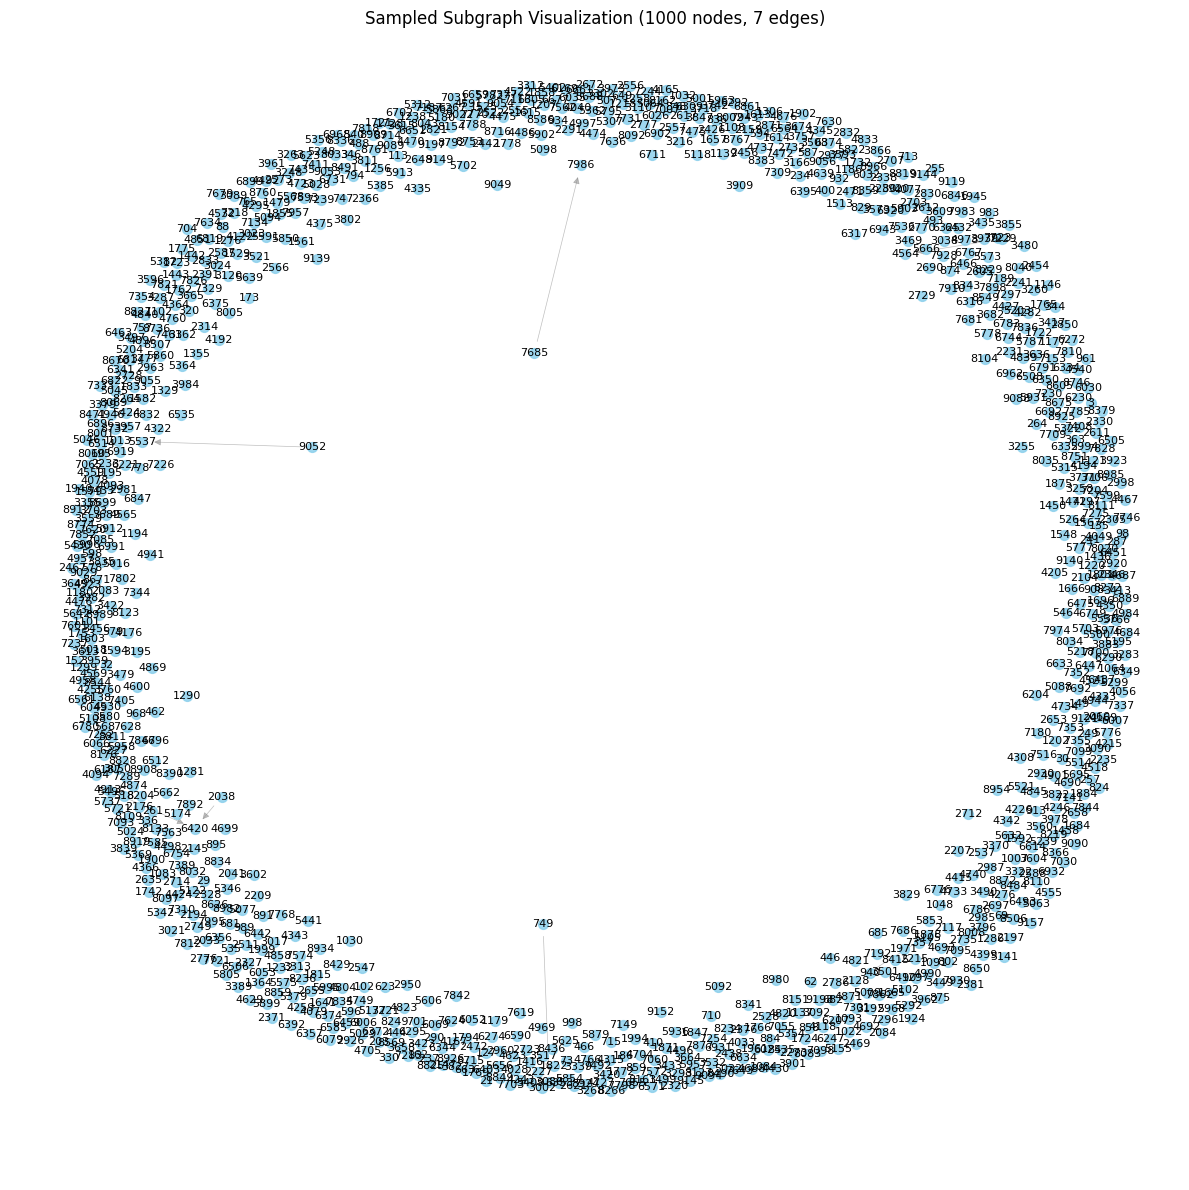

In [12]:
logging.info(f"Loading graph from {GRAPH_FILE}...")
if not os.path.exists(GRAPH_FILE):
    logging.error(f"Graph file '{GRAPH_FILE}' not found.")

try:
    # Load the graph with integer node IDs
    G = nx.read_gexf(GRAPH_FILE, node_type=int)
    logging.info(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
except Exception as e:
    logging.error(f"Failed to load graph from {GRAPH_FILE}: {e}")

if G.number_of_nodes() == 0:
    logging.warning("Graph is empty, nothing to visualize.")

logging.info("Loading mappings...")
mappings = load_json_file(MAPPING_FILE)
if mappings is None or 'id_to_url' not in mappings:
    logging.error("Failed to load ID-to-URL mappings. Node labels will be IDs.")
    id_to_url = {}
else:
    # Convert string keys from JSON back to integers for id_to_url
    id_to_url = {int(k): v for k, v in mappings['id_to_url'].items()}
    logging.info("Mappings loaded.")

# --- Sample Nodes ---
num_nodes_to_sample = min(SAMPLE_SIZE, G.number_of_nodes())
if num_nodes_to_sample <= 0:
        logging.warning("Sample size is zero or negative, cannot visualize.")

logging.info(f"Sampling {num_nodes_to_sample} nodes for visualization...")
sampled_nodes = random.sample(list(G.nodes()), num_nodes_to_sample)

# --- Create Subgraph ---
# This creates a new graph containing only the sampled nodes
# and the edges that exist *between* those sampled nodes in the original graph.
subgraph = G.subgraph(sampled_nodes).copy() # Use copy to allow modification if needed later
logging.info(f"Created subgraph with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")

if subgraph.number_of_nodes() == 0:
    logging.warning("Subgraph is empty (no nodes sampled?), cannot visualize.")

# --- Prepare for Visualization ---
logging.info("Calculating layout for the subgraph (this may take a moment)...")
# Use a layout algorithm to position nodes
# spring_layout is common, others include kamada_kawai_layout, circular_layout, etc.
pos = nx.spring_layout(subgraph, k=0.15, iterations=50) # Adjust k for spacing, iterations for convergence

# Create labels for the nodes in the subgraph
labels = get_node_labels(subgraph.nodes(), id_to_url, LABEL_TYPE)

# --- Visualize ---
logging.info("Drawing graph...")
plt.figure(figsize=(12, 12)) # Adjust figure size as needed

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=NODE_SIZE, node_color='skyblue', alpha=0.8)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, width=0.5, edge_color='gray', alpha=0.5, arrows=True, arrowsize=10)

# Draw labels
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=FONT_SIZE)

plt.title(f"Sampled Subgraph Visualization ({subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges)")
plt.axis('off') # Hide the axes
plt.tight_layout()
logging.info("Displaying plot...")
plt.show() # Display the plot in a new window